In [5]:
%matplotlib inline
import torch
from cebm.utils import load_models, init_models

model_name = 'CEBM_VERA'
data = 'mnist'
device = torch.device('cuda:1')
if data in ['mnist', 'fmnist']:
    lambda_ent = 1.0
    network_args = {'device': device,
                    'im_height': 28, 
                    'im_width': 28, 
                    'input_channels': 1, 
                    'channels': [32,32,64,64], 
                    'kernels': [3,4,4,4], 
                    'strides': [1,2,2,2], 
                    'paddings': [1,1,1,1],
                    'hidden_dims': [256],
                    'latent_dim': 128,
                    'activation': 'SiLU',
                    'dec_paddings': [1,1,0,0],
                    'xee_init_sigma': 0.1,
                    'leak_slope': 0.2,
                    'gen_channels': [64,64,32,32,1], 
                    'gen_kernels': [4,4,3,4,4], 
                    'gen_strides': [1,2,2,2,2], 
                    'gen_paddings': [1,1,1,1,1],
                    'gen_activation': 'ReLU',
                    'output_arch': 'mlp',
                   }
else:
    lambda_ent = 1e-4
    network_args = {'device': device,
                    'im_height': 32, 
                    'im_width': 32, 
                    'input_channels': 3, 
                    'channels': [64,128,256,512],
                    'kernels': [3,4,4,4], 
                    'strides': [1,2,2,2], 
                    'paddings': [1,1,1,1],
                    'hidden_dims': [1024], 
                    'latent_dim': 128,
                    'activation': 'SiLU',
                    'dec_paddings': [1,1,0,0],
                    'xee_init_sigma': 0.1,
                    'leak_slope': 0.2,
                    'gen_channels': [512,256,128,64,3], 
                    'gen_kernels': [4,4,4,4,4], 
                    'gen_strides': [2,2,2,2,2], 
                    'gen_paddings': [1,1,1,1,1],
                    'gen_activation': 'ReLU',
                    'output_arch': 'mlp',
                   }
    
model_args = {'optimize_ib': False,
              'num_clusters': 20}
models = init_models(model_name, device, model_args, network_args)
exp_name = '%s_d=%s_z=%s_lamb=%s' % (model_name, data, network_args['latent_dim'], lambda_ent)
if model_args['optimize_ib']:
    exp_name += '_learn-ib'
load_models(models, exp_name)

In [2]:
# from cebm.eval import Evaluator
# evaluator = Evaluator(device, models, model_name, data)
# results = evaluator.few_label_classification()

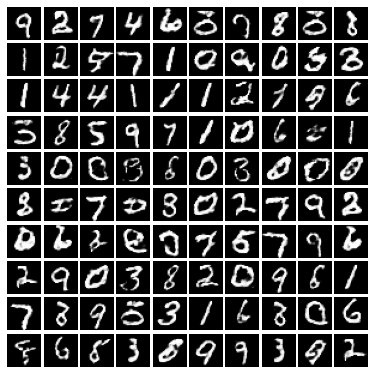

In [3]:
from cebm.eval import plot_samples
z, x, x_mu = models['gen'].sample(100)
plot_samples(x_mu, denormalize=True, fs=0.5)

In [6]:
import matplotlib.pyplot as plt
from cebm.data import setup_data_loader
import numpy as np
from sklearn.manifold import TSNE
batch_size=1000
dataset_args = {'data': data, 
                'data_dir': '../datasets/', 
                'num_shots': -1,
                'batch_size': batch_size,
                'train': False, 
                'normalize': True}
test_loader, _, _, _ = setup_data_loader(**dataset_args)
mus = []
sigmas = []
ys = []
for b, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    z_mu, z_sigma = models['ebm'].latent_params(images)
    mus.append(z_mu.detach().cpu().numpy())
    sigmas.append(z_sigma.detach().cpu().numpy())
    ys.append(labels.numpy())
mus = np.concatenate(mus, 0)
sigmas = np.concatenate(sigmas, 0)
ys = np.concatenate(ys, 0)

# # zs2 = TSNE(n_components=2).fit_transform(zs)


In [10]:
sigmas[3]

array([0.99753016, 0.7985434 , 0.8026702 , 0.7857158 , 0.66966766,
       0.8150601 , 0.72609484, 0.80370295, 0.7109874 , 0.72284853,
       0.9997824 , 0.9983833 , 0.7446469 , 0.74125445, 0.58079505,
       0.8385304 , 0.54906625, 0.8152666 , 0.7363598 , 0.7046897 ,
       0.54241276, 0.6535871 , 0.7543358 , 0.69511944, 0.60519606,
       0.74045813, 0.6156549 , 0.8730277 , 0.72049135, 0.68499887,
       0.98468846, 0.7283183 , 0.81520486, 0.8126369 , 0.8545782 ,
       0.80406725, 0.67031723, 0.7568148 , 0.69640505, 0.96965736,
       0.61811787, 0.998816  , 0.70898116, 0.6317125 , 0.8351213 ,
       0.7305852 , 0.9970295 , 0.704386  , 0.8054667 , 0.9563105 ,
       0.8560807 , 0.99757916, 0.62477845, 0.70554173, 0.6755695 ,
       0.7042731 , 0.77686906, 0.83257115, 0.606652  , 0.8113295 ,
       0.67137074, 0.8668489 , 0.8430925 , 0.58363646, 0.24665864,
       0.9153552 , 0.9832984 , 0.95260143, 0.59685034, 0.7319271 ,
       0.622391  , 0.6249794 , 0.671295  , 0.97128356, 0.76680

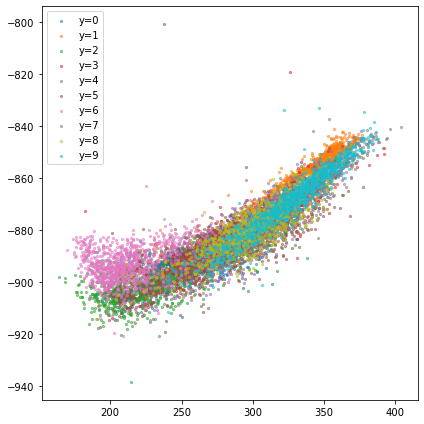

In [8]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
colors=[]
for k in range(10):
    m = (ys == k)
    p = ax.scatter(zs[m, 0], zs[m, 1], label='y=%d' % k, alpha=0.5, s=5)
    colors.append(p.get_facecolor())
ax.legend()
fig.tight_layout()
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
plt.savefig('cebm_gmm_vera_z=2.png')

In [ ]:
from cebm.eval import uncond_sampling
sgld_args = {'im_h': network_args['im_height'], 
             'im_w':  network_args['im_width'], 
             'im_channels':  network_args['input_channels'],
             'device': device,
             'alpha': 2.0,
             'noise_std': 1e-3,
             'buffer_size': 1,
             'reuse_freq': 1}

sgld_steps = 1000
batch_size = 100
uncond_sampling(models, sgld_steps, batch_size, sgld_args, init_samples=None)

In [ ]:
import hamiltorch
import matplotlib.pyplot as plt
from cebm.data import setup_data_loader
from tqdm import tqdm

num_hmc_steps = 500
step_size = 1e-3
num_leapfrog_steps = 10
batch_size = 1

dataset_args = {'data': data, 
                'data_dir': '../datasets/', 
                'num_shots': -1,
                'batch_size': batch_size,
                'train': False, 
                'normalize': True}
test_loader, _, _, _ = setup_data_loader(**dataset_args)
for b, (imgs, labels) in enumerate(test_loader):
    imgs = imgs.to(device)
    E_data = models['ebm'].energy(imgs)
#     z_mu, z_sigma = models['ebm'].latent_params(imgs)
    break
    
# z_mu = z_mu.detach()

x_data = imgs[0][None]
v_data = torch.atanh(x_data).flatten().to(device)
# # initialize a variable v \in [-inf ,inf] using atanh()
x_init = (torch.rand((1, 1, 28, 28)) - 0.5) / 0.5
v_init = torch.atanh(x_init).flatten().to(device)
# # v_init = torch.atanh(imgs[0][None]).flatten().to(device)
samples_noise = [x_init.cpu()]
samples_data = [x_data.cpu()]


# def log_prob(v_init):
#     nss1, nss2 = models['ebm'].forward(torch.tanh(v_init).reshape(1,1,28,28))
#     return ((nss1 * z_mu).sum(1) + (nss2 * (z_mu**2)).sum(1)).sum() 
    

def log_prob(v_init):
    return  -models['ebm'].energy(torch.tanh(v_init).reshape(1,1,28,28)).sum()

v_noise_final = hamiltorch.sample(log_prob, 
                            v_init, 
                            num_samples=num_hmc_steps, 
                            step_size=step_size, 
                            num_steps_per_sample=num_leapfrog_steps)    

v_data_final = hamiltorch.sample(log_prob, 
                            v_data, 
                            num_samples=num_hmc_steps, 
                            step_size=step_size, 
                            num_steps_per_sample=num_leapfrog_steps)    

In [ ]:
def compute_energy(v_final, samples):
    for v in v_final:
        x = torch.tanh(v.reshape(1,1,28,28))
        samples.append(x.cpu().detach())
    samples = torch.cat(samples, 0)   
    E_hmc = models['ebm'].energy(samples.to(device)).cpu().data.numpy()
    return samples, E_hmc

def plot_hmc(E_hmc, samples):
    fig = plt.figure(figsize=(3, 5))
    ax = fig.add_subplot(111)
    ax.plot(E_hmc, label='HMC')
    ax.set_ylabel('E(x)')
    ax.plot(torch.arange(len(E_hmc)), torch.ones(len(E_hmc)) * E_data[0].item(), label='E(x_data)')
    ax.legend()

    fs = 0.7
    fig = plt.figure(figsize=(fs, fs))
    ax = fig.add_subplot(111)
    ax.imshow(samples[0][0] * 0.5 + 0.5, cmap='gray', vmin=0.0, vmax=1.0)
    ax.set_xticks([])
    ax.set_yticks([])
    plot_samples(samples[-20:], denormalize=True, fs=fs)

In [ ]:
samples_data_final, E_hmc_data = compute_energy(v_data_final, samples_data)
samples_noise_final, E_hmc_noise = compute_energy(v_noise_final, samples_noise)

plot_hmc(E_hmc_data, samples_data_final)

In [ ]:
plot_hmc(E_hmc_noise, samples_noise_final)

In [ ]:
# from cebm.mala import MALA_Sampler
# num_steps = 100
# lr = 0.01
# batch_size = 10
# mala_sampler =  MALA_Sampl er(im_h=network_args['im_height'],
#                              im_w=network_args['im_width'],
#                              im_channels=network_args['input_channels'],
#                              device=device,
#                              batch_size=batch_size,
#                              latent_dim=network_args['latent_dim'])

# x_init, x_final = mala_sampler.refine_MALA(models, num_steps, lr)